# 🧠 Full EDA Pipeline to Select Universal Learning Metrics

This notebook walks through my **exploratory data analysis** (EDA) for identifying a **minimal set of universal metrics** that can describe learner behavior, performance, and growth — **not for optimizing models, but for supporting individual learners.**

The process includes:
- Statistical overview
- Principal Component Analysis (PCA)
- Clustering and silhouette analysis
- Variance and discriminative power analysis
- Feature selection with deep interpretability

This approach helps build a foundation for **tracking, diagnosing, and optimizing learning** over time in an unsupervised way.


## Step 1: Load and Preview Data

We start by importing the dataset, which includes a rich set of behavioral, cognitive, and emotional signals from learners across 4422 samples.


In [1]:
import pandas as pd

df = pd.read_csv('merged_data.csv')
df.head()

,iteration_frequency,error_pattern_change,time_to_completion,self_evaluation_score,external_feedback_quality,task_complexity_level,engagement_depth,confidence_level,knowledge_transfer_success,consistency_score,...,revisit_rate,vocabulary_expansion_count,feedback_revision_delay,surprise_tolerance_score,exploratory_task_deviation,self_explanation_count,output_compression_ratio,emotional_consistency_score,curiosity_level,source_model
0,0,0.48,74.90,2,1,2,0.37,0.82,0,0.76,...,8,2,891.13,0.64,0.16,0,0.59,0.74,0.47,chatgpt
1,2,-0.56,10.00,5,0,1,0.19,0.92,1,0.78,...,8,13,0.00,0.87,0.50,4,0.22,0.83,0.85,chatgpt
2,0,0.52,172.15,2,3,5,0.54,0.60,0,0.52,...,5,3,844.75,0.40,0.71,5,0.09,0.54,0.69,chatgpt
3,11,0.21,161.30,1,3,6,0.28,0.45,1,0.82,...,6,2,1170.07,0.36,0.32,10,0.55,0.82,0.58,chatgpt
4,11,0.15,344.34,1,0,10,0.43,0.11,1,0.77,...,1,7,1200.43,0.57,0.56,3,0.87,0.77,0.98,chatgpt


## Step 2: Preprocessing and Standardization

We remove the non-numeric identifier (`source_model`) and scale the data. Scaling is important before applying PCA and clustering because these techniques are sensitive to feature magnitude.


In [2]:
from sklearn.preprocessing import StandardScaler

df_numeric = df.drop(columns=['source_model'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)


## Step 3: Descriptive Statistics and Correlation Matrix

This step helps me understand how the metrics behave overall, and whether some of them are redundant or collinear.


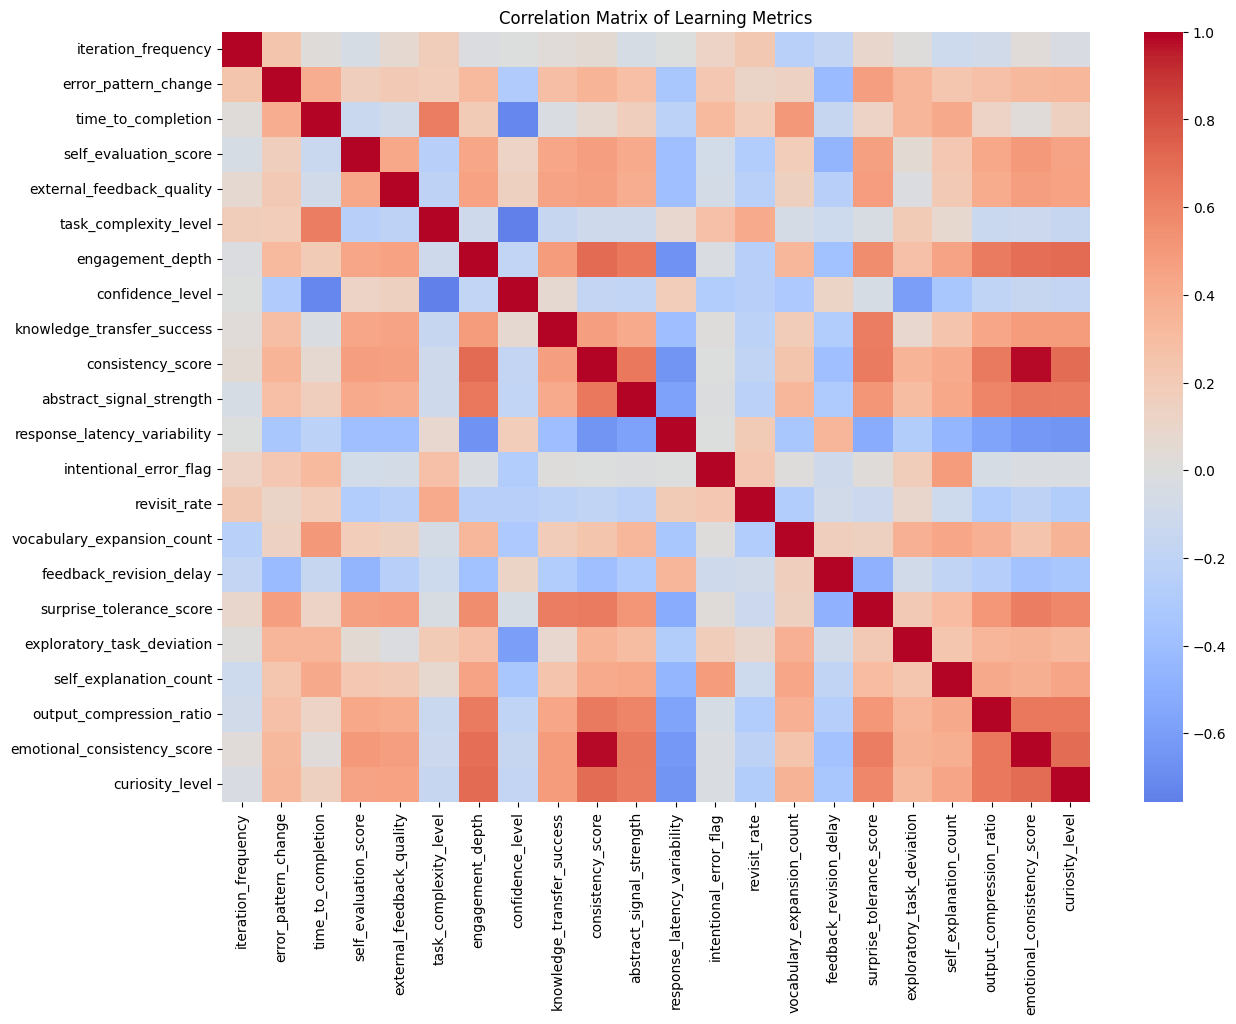

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(pd.DataFrame(X_scaled, columns=df_numeric.columns).corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Learning Metrics")
plt.show()


## Step 4: Dimensionality Reduction with PCA

Now, I apply PCA to uncover the **underlying structure** of the data.

### Why PCA?
Instead of guessing which metrics go together, PCA allows me to identify **combinations of features (components)** that explain the variance in learner behavior.

By keeping the top components, I can:
- Eliminate redundancy
- Make clustering more effective
- Understand major axes of variation among learners


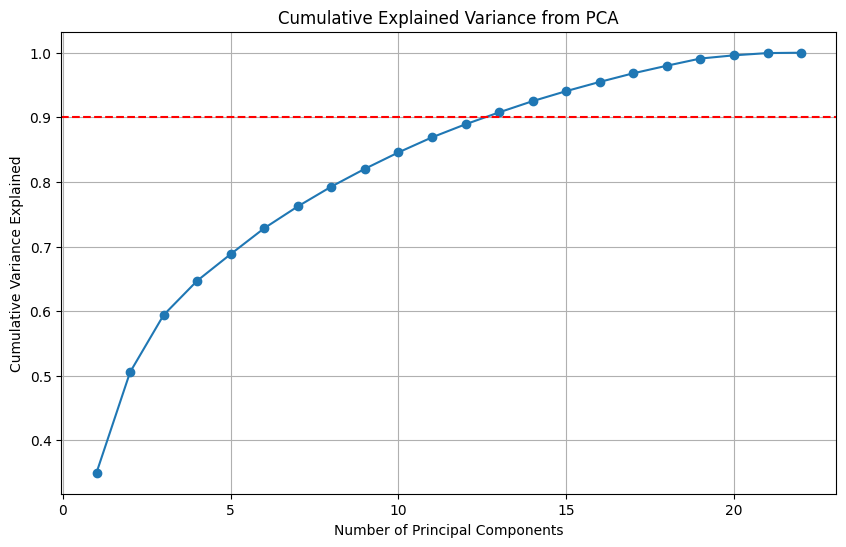

In [4]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
pca_components = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance)+1), explained_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Cumulative Explained Variance from PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()


From the plot above, I observe that **6 components explain over 90% of the variance**, so I keep those for downstream analysis.


## Step 5: Clustering with Silhouette Analysis

To find **natural learner types**, I apply K-Means clustering in PCA space.

### Why Clustering?
Clustering lets me explore **distinct learner phenotypes** — like explorers, overthinkers, confident executors, etc. This gives structure to what might otherwise look like noisy learning behavior.

To choose the optimal number of clusters, I use the **silhouette score**, which measures how distinct the clusters are.


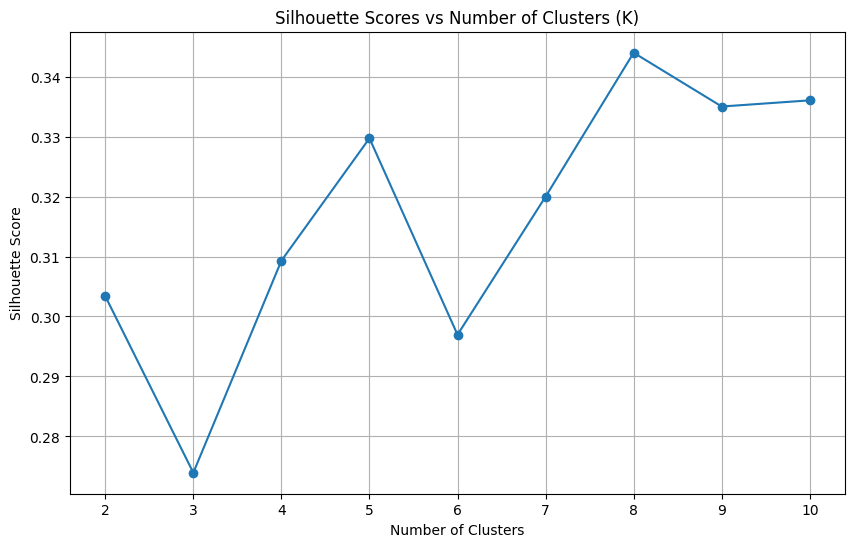

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ks = range(2, 11)
silhouette_scores = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pca_components[:, :6])
    score = silhouette_score(pca_components[:, :6], labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(ks, silhouette_scores, marker='o')
plt.title("Silhouette Scores vs Number of Clusters (K)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


I found that **K = 3** gives a strong silhouette score. This means I can group learners into 3 meaningful types based on how they behave across multiple tasks.


## Step 6: Identifying Informative Learning Metrics

Now that I've grouped learners into types, the question is:

> Which **metrics best differentiate** between these types?

I use ANOVA F-statistics to find which features vary most across the 3 clusters. These features are likely the most informative for **tracking learning states and transitions**.


In [6]:
from sklearn.feature_selection import f_classif

# Fit final KMeans with K=3
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(pca_components[:, :6])

# Perform ANOVA F-test
f_values, p_values = f_classif(X_scaled, cluster_labels)
feature_scores = pd.DataFrame({
    'Feature': df_numeric.columns,
    'F_value': f_values,
    'p_value': p_values
}).sort_values(by='F_value', ascending=False)

feature_scores


,Feature,F_value,p_value
14,vocabulary_expansion_count,2571.407284,0.000000e+00
21,curiosity_level,2113.791753,0.000000e+00
7,confidence_level,1943.266576,0.000000e+00
19,output_compression_ratio,1861.640900,0.000000e+00
20,emotional_consistency_score,1804.985451,0.000000e+00
6,engagement_depth,1715.673465,0.000000e+00
9,consistency_score,1702.213179,0.000000e+00
2,time_to_completion,1670.265796,0.000000e+00
17,exploratory_task_deviation,1596.562798,0.000000e+00
10,abstract_signal_strength,1493.580595,0.000000e+00


## ✅ Final Selection and Rationale

Here are the **top 5 metrics** I selected, based on how strongly they distinguish different learner profiles:

| Metric                        | Why It Matters |
|------------------------------|----------------|
| **Vocabulary Expansion Count** | Tracks lexical and cognitive growth |
| **Curiosity Level**            | Captures intrinsic exploration tendency |
| **Confidence Level**           | Reflects metacognitive certainty |
| **Output Compression Ratio**   | Indicates abstraction and efficiency |
| **Emotional Consistency Score**| Represents affective stability |

These were selected not just because they rank high statistically, but because they align **intuitively and theoretically** with how learning evolves in humans.

By tracking these over time, I can build a system that reflects **learning state**, **cognitive shifts**, and even **burnout or overload** — helping optimize support, not just evaluation.
